In [1]:
import os
import sys
import csv
import pickle
from collections import Counter
from datetime import datetime

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit

import torch
from torch import nn
from torch.utils.data import DataLoader
from network import TweetyNet
import librosa
from librosa import display
from microfaune.audio import wav2spc, create_spec, load_wav
from glob import glob

from torch.utils.data import Dataset
from CustomAudioDataset import CustomAudioDataset

from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import scipy
import IPython.display as ipd

In [2]:
def mywav2spc(wav_file, fs=44100, win_length=88, n_mels=40, n_fft=2048, hop_len=1024, start=0, duration=None):
    """Load a wav file and compute its MEL spectogram.

    Parameters
    ----------
    wav_file: str
        path to a wav file.
    fs: int
        Sampling frequency in Hz.
    n_mels: int
        Number of Mel bands to generate.
    n_fft: int
        Length of the FFT window.
    hop_len: int
        Number of samples between successive frames.
    start: int
        start of the sound to consider
    duration: int
        Duration of the sound to consider (starting at the beginning)
        If None, no truncature is made

    Returns
    --------
    specs: array of array-like
        Array-like of shape (Mel bands, time) containing the spectrogram.
    """

    x_fs, all_x = load_wav(wav_file)
    x = np.copy(all_x)
    specs = []
    starts = []
    ends = []
    curr_duration = duration
    #print("Length of wav:", len(x))
    i =0
    while (curr_duration is None) or (curr_duration < len(all_x) or (start < len(all_x))):
        #print("splits:", i, start, curr_duration)
        i+=1
        #print("before", len(x))
        if curr_duration is not None:
            diff = 0
            if curr_duration > len(all_x):
                diff = curr_duration-len(all_x)
                curr_duration = len(all_x)
            x = np.copy(all_x[int(start) :int(curr_duration) + 1])
            if diff > 0:
                print("appending", len(x), diff)
                x= np.append(x, np.zeros(diff))
        else:
            curr_duration = len(x)
            duration = len(x)
        #print("after", len(x))

        if x_fs != fs:
            raise ValueError(f"wav file with wrong frequency {x_fs}: {wav_file}")
        spec = my_create_spec(x, fs, win_length, n_mels, n_fft, hop_len)
        #if start >= 8184 and start < 8272:
        #    scipy.io.wavfile.write("prac_data/" + os.path.basename(wav_file) + str(start) + ".wav", fs, x)
        specs.append(spec)
        starts.append(start)
        ends.append(curr_duration)
        start = curr_duration
        curr_duration += duration
    return specs, starts, ends, x_fs
def my_create_spec(data, fs, win_length = 88, n_mels=32, n_fft=2048, hop_len=1024):
    S = librosa.feature.melspectrogram(
      data, sr=fs, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels, win_length = win_length)
    S = S.astype(np.float32)

    # Convert power to dB
    S = librosa.power_to_db(S)
    return S

In [3]:
HOP_LENGTH = 1024
FRAME_SIZE = 2048
SR = 32000
data_dir = "/Users/mugetronblue/E4E/AcousticSpecies/passive-acoustic-biodiversity/TweetyNET/data/BirdSong_Recognition/"


In [4]:
x, sr = librosa.load(os.path.join(data_dir, "Bird0", "Wave", "0.wav"), sr=32000)

print(type(x), type(sr))
print(x.shape, sr)

<class 'numpy.ndarray'> <class 'int'>
(245088,) 32000


In [5]:
def wav2stft(path, sr, frame_size, hop_length):
    x, sr = librosa.load(path, sr=sr)
    X = librosa.stft(x, n_fft=frame_size, hop_length = hop_length)
    return X

In [43]:
def show_spectrogram(spec, hop_length):
    fig, ax = plt.subplots()
    M_db_bird = librosa.power_to_db(spec, ref=np.max)
    img = librosa.display.specshow(M_db_bird, sr=32000, hop_length=hop_length, y_axis='hz', x_axis='time', ax=ax)
    ax.set(title='spectrogram Bird0')
    plt.show()

In [44]:
X = wav2stft(os.path.join(data_dir, "Bird0", "Wave", "0.wav"), SR, FRAME_SIZE, HOP_LENGTH) #Output(#frequency bins, #frames)

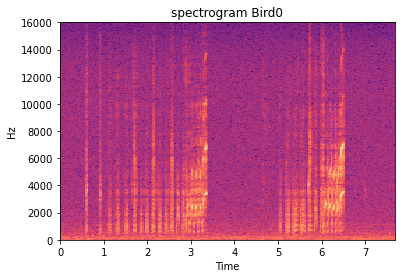

In [45]:
show_spectrogram(X,HOP_LENGTH)

In [9]:
def get_frequency_bins(frame_size):
    return 1/2.0 * frame_size + 1
# can use this function to reverse engineer how time can map to spectrograms
def get_frames(x, frame_size, hop_length): 
    return ((x) / hop_length) + 1#(x - frame_size)/hop_length + 1
def frames2seconds(x, sr):
    return x/sr

In [10]:
print(get_frequency_bins(FRAME_SIZE))
print(get_frames(len(x), FRAME_SIZE, HOP_LENGTH))
print(frames2seconds(len(x), SR))
len(x), x.shape, len(X), X.shape

1025.0
240.34375
7.659


(245088, (245088,), 1025, (1025, 240))

In [11]:
get_frames(8000, FRAME_SIZE, HOP_LENGTH)

8.8125

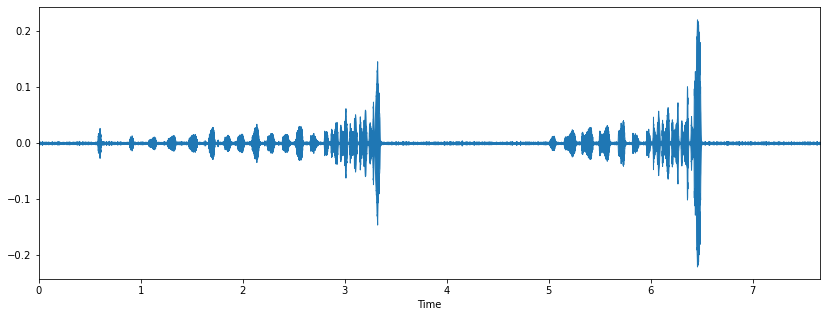

In [12]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)

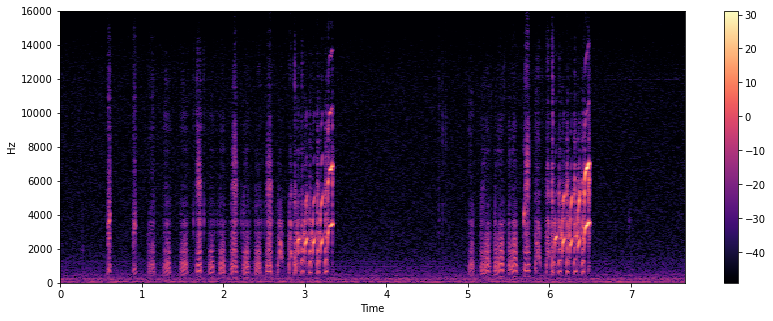

In [13]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()# looks better in terms of time.


In [14]:
Xdb.shape

(1025, 479)

/Users/mugetronblue/opt/anaconda3/envs/species-id/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/mugetronblue/opt/anaconda3/envs/species-id/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/mugetronblue/opt/anaconda3/envs/species-id/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linscaley' parameter of __init__() has been renamed 'linscale' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


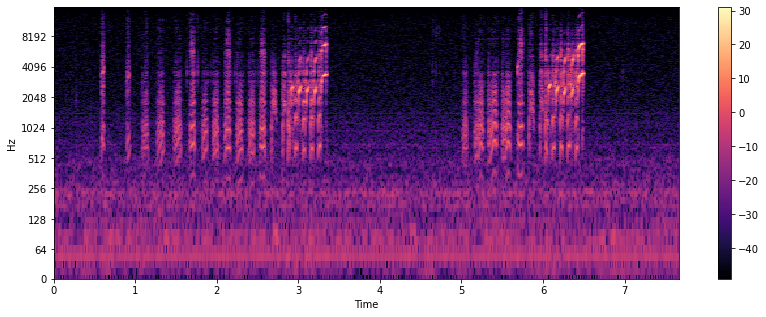

In [15]:
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

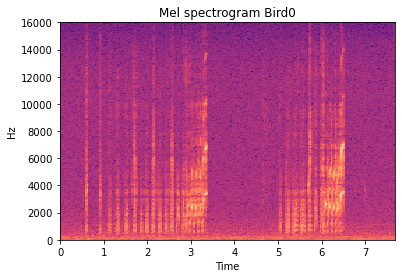

(1025, 240)

In [16]:
X = librosa.stft(x, n_fft=FRAME_SIZE, hop_length = HOP_LENGTH)
show_spectrogram(X, HOP_LENGTH)
X.shape

In [17]:
ipd.Audio(os.path.join(data_dir, "Bird0", "Wave", "0.wav"))

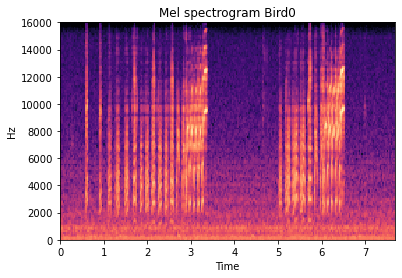

(128, 240)

In [18]:
spec = wav2spc(os.path.join(data_dir, "Bird0", "Wave", "0.wav"), fs = 32000, n_mels=128, n_fft=2048, hop_len=1024, duration=None)
show_spectrogram(spec, HOP_LENGTH)
spec.shape

In [19]:
spec.shape
#maybe it is stacked. 

(128, 240)

(1, 40, 240)


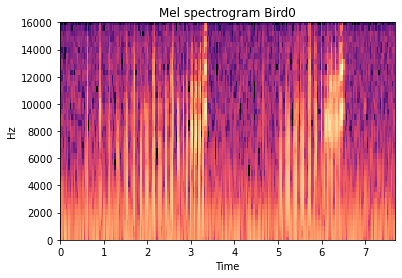

In [20]:
spec2 = mywav2spc(os.path.join(data_dir, "Bird0", "Wave", "0.wav"), fs = 32000, win_length=88, n_mels=40, n_fft=2048, hop_len=1024)[0]
print(np.array(spec2).shape)
show_spectrogram(spec2[0], HOP_LENGTH)


In [21]:
spec2[0][0].shape

(240,)

In [22]:
def load_dataset(data_path, bird_name, sr, frame_size, hope_length, use_dump=True):
    mel_dump_file = os.path.join(data_path, bird_name, "mel_dataset.pkl")
    if os.path.exists(mel_dump_file) and use_dump:
        with open(mel_dump_file, "rb") as f:
            dataset = pickle.load(f)
    else:
        dataset = compute_bird_features(os.path.join(data_path, bird_name), sr, frame_size, hope_length)
        with open(mel_dump_file, "wb") as f:
            pickle.dump(dataset, f)
    inds = [i for i, x in enumerate(dataset["X"])]
    X = np.array([dataset["X"][i].transpose() for i in inds], dtype='object')
    Y = np.array([dataset["Y"][i] for i in inds])
    uids = [dataset["uids"][i] for i in inds]
    return X, Y, uids

def compute_feature(data_path, sr, frame_size, hop_length):
    print(f"Compute features for dataset {os.path.basename(data_path)}")
    labels_file = os.path.join(data_path, "Annotation.xml")
    print(labels_file)
    labels = None
    if os.path.exists(labels_file):
        annotations = load_annotation(labels_file)
        annotation_checker(annotations)
        #find_max_time(annotations, "0.wav")
        labels = annotations["label"]
        file_names = annotations["filename"]
        #for i in range(5):#len(annotations["filename"])):
        #    print(annotations["filename"][i], annotations["start"][i], annotations["duration"][i], annotations["label"][i], annotations["maxlength"][i], annotations["maxposition"][i])
        distinct_labels = {}
        spect_dict = { "filename" : [], "spectrograms" : [] , "fs" : [], "starts" : [], "ends" : [], "windowlength" : [] }
        for fille in file_names:
            if fille not in distinct_labels:
                print(fille)
                distinct_labels[fille] = 1
                spc = wav2stft(os.path.join(data_path, "Wave", fille), sr = sr, frame_size=frame_size, hop_length=hop_length)
                spect_dict["filename"].append(fille)
                spect_dict["spectrograms"].append(spc)
        print("num of spectrograms:", len(spect_dict["spectrograms"][0]))
    return annotations, spect_dict
    #write a new function in this place. to lineup annotations and spectrograms.
    




In [39]:
#revamp the parsing!
def load_annotation(data_path):
    annotations = {
            "filename" : [],
            "start" : [],
            "duration" : [],
            "label" : [],
            "maxposition" : [],
            "maxlength" : []
        }
    with open(data_path, 'r') as f:
        data = f.read()
        filename = None
        maxposition = None
        maxlength = None
        start = None
        duration = None
        label = None
        length, data = data.split("</NumSequence><Sequence>")
        length = length.split(">")[-1]
        notes = data.split("</Note>")[:-1]
        filecount = 0
        notecount = 0
        labels = set()
        label_mapping = {}
        for i in range(0,len(notes)):
            if "<WaveFileName>" in notes[i]:
                filename = notes[i].split("</WaveFileName>")[0].split(">")[-1]
                maxposition = notes[i].split("</Position>")[0].split(">")[-1]
                maxlength = notes[i].split("</Length>")[0].split(">")[-1]
                #print("fname:", filename)
                #print("max_pos:", maxposition)
                #print("max_length: ", maxlength)
                filecount+=1
            else:
                notecount += 1
                start = notes[i].split("</Position>")[0].split(">")[-1]
                duration = notes[i].split("</Length>")[0].split(">")[-1]
                label = notes[i].split("</Label>")[0].split(">")[-1]
                if not label.isnumeric():
                    label_mapping[label] = None
                else:
                    labels.add(int(label))
        sort_labels = sorted(labels)
        maxo = sort_labels[-1]
        print(maxo)
        keys_label = sorted(label_mapping.keys())
        for k in keys_label:
            label_mapping[k] = maxo
            maxo += 1
        for i in range(0,len(notes)):
            if "<WaveFileName>" in notes[i]:
                filename = notes[i].split("</WaveFileName>")[0].split(">")[-1]
                maxposition = notes[i].split("</Position>")[0].split(">")[-1]
                maxlength = notes[i].split("</Length>")[0].split(">")[-1]
                #print("fname:", filename)
                #print("max_pos:", maxposition)
                #print("max_length: ", maxlength)
                filecount+=1
            else:
                notecount += 1
                start = notes[i].split("</Position>")[0].split(">")[-1]
                duration = notes[i].split("</Length>")[0].split(">")[-1]
                label = notes[i].split("</Label>")[0].split(">")[-1]
                if not label.isnumeric():
                    label = label_mapping[label]
                annotations["filename"].append(filename)
                annotations["start"].append(int(start))
                annotations["duration"].append(int(duration))
                annotations["label"].append(label)
                annotations["maxposition"].append(int(maxposition))
                annotations["maxlength"].append(int(maxlength))
                #print("max_pos:", int(maxposition))
                #print("max_length: ", int(maxlength))
                #if i ==1:
                #    print("start:", start)
                #    print("duration:", duration)
                #    print("label:", label)
        print("Labels:", labels)
        print("Label Mapping:", label_mapping)
        print("Length:", length)
        print("File Count:", filecount)
        print("Note Count:", notecount)

    return annotations


In [31]:
def annotation_checker(annotations):
    for f in annotations:
        if f == "filename" or f == "label":
            continue
        else:
            for i in range(len(annotations[f])):
                if not (isinstance(annotations[f][i], int)):
                    print("failed:", annotations[f][i])


def find_max_time(annotations, filename):
    themax = 0
    start = 0
    duration = 0
    for i in range(len(annotations["filename"])):
        if annotations["filename"][i] == filename:
            if themax < annotations["start"][i] + annotations["duration"][i]:
                themax = annotations["start"][i] + annotations["duration"][i]
                start = annotations["start"][i]
                duration = annotations["duration"][i]
    print(themax, start, duration)


def get_bird_data(data_dir):
    annotations = []
    for i in range(0, 1):
        #print(os.path.join(data_dir, "Bird"+str(i)+"/Annotation.xml"))
        return compute_feature(os.path.join(data_dir, "Bird"+str(i)))
        #annotations.append(load_annotation(os.path.join(data_dir, "Bird"+str(i)+"/Annotation.xml")))


In [32]:
#can do sorting if this is slow.
def create_X(spect_dict):
    X = {"filename" : [], "X" : []}
    for i in range(len(spect_dict["spectrograms"])):
        X["X"].append(spect_dict["spectrograms"][i])
        X["filename"].append(spect_dict["filename"])
    return X
def create_Y(spect_dict):
    Y = {"filename" : [], "Y" : []}
    for i in range(len(spect_dict["spectrograms"])):
        Y["Y"].append(create_a_Y(spect_dict["spectrograms"][i]))
        Y["filename"].append(spect_dict["filename"][i])
    return Y
def create_a_Y(spec):
    return np.array([0]*(spec.shape[1]))

In [26]:
def zip_it_up(annotations, spect_dict, frame_size, hop_length):
    #Must flatten everything
    #let's prefill Y with 0s, and then go back and fill
    i = 1
    X = create_X(spect_dict)
    Y = create_Y(spect_dict) #ordered by filename
    uids = Y["filename"]
    found = {}
    # A clip is more strongly labeled here. Let's say if a spectrogram contains a birdsong then label it, otherwise it is 0 
    # here I need to organize it all and give the spectrograms there labels. 
    # can be optimized
    for j in range(len(spect_dict["filename"])):
        for k in range(len(annotations["filename"])):
            f_name = annotations["filename"][k]
            _start = annotations["start"][k]
            _duration = annotations["duration"][k]
            _label = annotations["label"][k]
            _file_start = annotations["maxposition"][k]
            #filename + start + end
            if f_name == spect_dict["filename"][j]:
                # we found the same file.
                idx = -1
                for m in range(0, len(Y["filename"])):
                    #print(Y["filename"][m])
                    if Y["filename"][m] == f_name:
                        idx = m
                        break
                if idx == -1:
                    print("File not found in Y:", f_name)
                    return None
                #inclusive -> these should be our indices
                lowerbound = round(get_frames(_file_start + _start , frame_size, hop_length))
                upperbound = round(get_frames(_file_start + _start + _duration, frame_size, hop_length))
                for l in range(lowerbound, upperbound+1):
                    Y["Y"][idx][l] = _label
                    i += 1
                    if i%10000 == 0:
                        print("finished", i)
    return {"X": X["X"], "Y": Y["Y"], "uids": uids}

In [27]:
def compute_bird_features(data_dir, sr, frame_size, hop_length):
    annotations, spect_dict = compute_feature(data_dir, sr, frame_size, hop_length)
    return zip_it_up(annotations, spect_dict, frame_size, hop_length)
 

In [40]:
annotations, spect_dict = compute_feature(os.path.join(data_dir, "Bird2"), SR, FRAME_SIZE, HOP_LENGTH)


Compute features for dataset Bird2
/Users/mugetronblue/E4E/AcousticSpecies/passive-acoustic-biodiversity/TweetyNET/data/BirdSong_Recognition/Bird2/Annotation.xml
9
Labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Label Mapping: {'a': 9, 'b': 10, 'c': 11, 'd': 12, 'e': 13, 'f': 14, 'g': 15}
Length: 1853
File Count: 3706
Note Count: 48548
0.wav
1.wav
2.wav
3.wav
4.wav
5.wav
6.wav
7.wav
8.wav
9.wav
10.wav
11.wav
12.wav
13.wav
14.wav
15.wav
16.wav
17.wav
18.wav
19.wav
20.wav
21.wav
22.wav
23.wav
24.wav
25.wav
26.wav
27.wav
28.wav
29.wav
30.wav
31.wav
32.wav
33.wav
34.wav
35.wav
36.wav
37.wav
38.wav
39.wav
40.wav
41.wav
42.wav
43.wav
44.wav
45.wav
46.wav
47.wav
48.wav
49.wav
50.wav
51.wav
52.wav
53.wav
54.wav
55.wav
56.wav
57.wav
58.wav
59.wav
60.wav
61.wav
62.wav
63.wav
64.wav
65.wav
66.wav
67.wav
68.wav
69.wav
70.wav
71.wav
72.wav
73.wav
74.wav
75.wav
76.wav
77.wav
78.wav
79.wav
80.wav
81.wav
82.wav
83.wav
84.wav
85.wav
86.wav
87.wav
88.wav
89.wav
90.wav
91.wav
92.wav
93.wav
94.wav
95.wav
96.wav
97

In [40]:
output = zip_it_up(annotations, spect_dict, FRAME_SIZE, HOP_LENGTH)

finished 10000
finished 20000
finished 30000
finished 40000
finished 50000
finished 60000
finished 70000
finished 80000
finished 90000


In [30]:
Y = create_Y(spect_dict)
d = 78
spect_dict["filename"][d], Y["Y"][d].shape, spect_dict["spectrograms"][d].shape

('78.wav', (346,), (1025, 346))

In [31]:
spect_dict["spectrograms"][0].shape[1]
#not great, input size is not always consistent


240

In [42]:
for a in range(1, 11):
    load_dataset(data_dir, "Bird"+str(a), SR, FRAME_SIZE, HOP_LENGTH, use_dump=True)

Compute features for dataset Bird1
/Users/mugetronblue/E4E/AcousticSpecies/passive-acoustic-biodiversity/TweetyNET/data/BirdSong_Recognition/Bird1/Annotation.xml
9
Labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Label Mapping: {'a': 9, 'c': 10}
Length: 2500
File Count: 5000
Note Count: 66456
0.wav
1.wav
2.wav
3.wav
4.wav
5.wav
6.wav
7.wav
8.wav
9.wav
10.wav
11.wav
12.wav
13.wav
14.wav
15.wav
16.wav
17.wav
18.wav
19.wav
20.wav
21.wav
22.wav
23.wav
24.wav
25.wav
26.wav
27.wav
28.wav
29.wav
30.wav
31.wav
32.wav
33.wav
34.wav
35.wav
36.wav
37.wav
38.wav
39.wav
40.wav
41.wav
42.wav
43.wav
44.wav
45.wav
46.wav
47.wav
48.wav
49.wav
50.wav
51.wav
52.wav
53.wav
54.wav
55.wav
56.wav
57.wav
58.wav
59.wav
60.wav
61.wav
62.wav
63.wav
64.wav
65.wav
66.wav
67.wav
68.wav
69.wav
70.wav
71.wav
72.wav
73.wav
74.wav
75.wav
76.wav
77.wav
78.wav
79.wav
80.wav
81.wav
82.wav
83.wav
84.wav
85.wav
86.wav
87.wav
88.wav
89.wav
90.wav
91.wav
92.wav
93.wav
94.wav
95.wav
96.wav
97.wav
98.wav
99.wav
100.wav
101.wav
102.wav
10

/Users/mugetronblue/opt/anaconda3/envs/species-id/lib/python3.7/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if sys.path[0] == '':


Compute features for dataset Bird2
/Users/mugetronblue/E4E/AcousticSpecies/passive-acoustic-biodiversity/TweetyNET/data/BirdSong_Recognition/Bird2/Annotation.xml
9
Labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Label Mapping: {'a': 9, 'b': 10, 'c': 11, 'd': 12, 'e': 13, 'f': 14, 'g': 15}
Length: 1853
File Count: 3706
Note Count: 48548
0.wav
1.wav
2.wav
3.wav
4.wav
5.wav
6.wav
7.wav
8.wav
9.wav
10.wav
11.wav
12.wav
13.wav
14.wav
15.wav
16.wav
17.wav
18.wav
19.wav
20.wav
21.wav
22.wav
23.wav
24.wav
25.wav
26.wav
27.wav
28.wav
29.wav
30.wav
31.wav
32.wav
33.wav
34.wav
35.wav
36.wav
37.wav
38.wav
39.wav
40.wav
41.wav
42.wav
43.wav
44.wav
45.wav
46.wav
47.wav
48.wav
49.wav
50.wav
51.wav
52.wav
53.wav
54.wav
55.wav
56.wav
57.wav
58.wav
59.wav
60.wav
61.wav
62.wav
63.wav
64.wav
65.wav
66.wav
67.wav
68.wav
69.wav
70.wav
71.wav
72.wav
73.wav
74.wav
75.wav
76.wav
77.wav
78.wav
79.wav
80.wav
81.wav
82.wav
83.wav
84.wav
85.wav
86.wav
87.wav
88.wav
89.wav
90.wav
91.wav
92.wav
93.wav
94.wav
95.wav
96.wav
97

188.wav
189.wav
190.wav
191.wav
192.wav
193.wav
194.wav
195.wav
196.wav
197.wav
198.wav
199.wav
200.wav
201.wav
202.wav
203.wav
204.wav
205.wav
206.wav
207.wav
208.wav
209.wav
210.wav
211.wav
212.wav
213.wav
214.wav
215.wav
216.wav
217.wav
218.wav
219.wav
220.wav
221.wav
222.wav
223.wav
224.wav
225.wav
226.wav
227.wav
228.wav
229.wav
230.wav
231.wav
232.wav
233.wav
234.wav
235.wav
236.wav
237.wav
238.wav
239.wav
240.wav
241.wav
242.wav
243.wav
244.wav
245.wav
246.wav
247.wav
248.wav
249.wav
250.wav
251.wav
252.wav
253.wav
254.wav
255.wav
256.wav
257.wav
258.wav
259.wav
260.wav
261.wav
262.wav
263.wav
264.wav
265.wav
266.wav
267.wav
268.wav
269.wav
270.wav
271.wav
272.wav
273.wav
274.wav
275.wav
276.wav
277.wav
278.wav
279.wav
280.wav
281.wav
282.wav
283.wav
284.wav
285.wav
286.wav
287.wav
288.wav
289.wav
290.wav
291.wav
292.wav
293.wav
294.wav
295.wav
296.wav
297.wav
298.wav
299.wav
300.wav
301.wav
302.wav
303.wav
304.wav
305.wav
306.wav
307.wav
308.wav
309.wav
310.wav
311.wav
312.wav


105.wav
106.wav
107.wav
108.wav
109.wav
110.wav
111.wav
112.wav
113.wav
114.wav
115.wav
116.wav
117.wav
118.wav
119.wav
120.wav
121.wav
122.wav
123.wav
124.wav
125.wav
126.wav
127.wav
128.wav
129.wav
130.wav
131.wav
132.wav
133.wav
134.wav
135.wav
136.wav
137.wav
138.wav
139.wav
140.wav
141.wav
142.wav
143.wav
144.wav
145.wav
146.wav
147.wav
148.wav
149.wav
150.wav
151.wav
152.wav
153.wav
154.wav
155.wav
156.wav
157.wav
158.wav
159.wav
160.wav
161.wav
162.wav
163.wav
164.wav
165.wav
166.wav
167.wav
168.wav
169.wav
170.wav
171.wav
172.wav
173.wav
174.wav
175.wav
176.wav
177.wav
178.wav
179.wav
180.wav
181.wav
182.wav
183.wav
184.wav
185.wav
186.wav
187.wav
188.wav
189.wav
190.wav
191.wav
192.wav
193.wav
194.wav
195.wav
196.wav
197.wav
198.wav
199.wav
200.wav
201.wav
202.wav
203.wav
204.wav
205.wav
206.wav
207.wav
208.wav
209.wav
210.wav
211.wav
212.wav
213.wav
214.wav
215.wav
216.wav
217.wav
218.wav
219.wav
220.wav
221.wav
222.wav
223.wav
224.wav
225.wav
226.wav
227.wav
228.wav
229.wav


In [42]:

bird0_data = load_dataset(data_dir, "Bird2", SR, FRAME_SIZE, HOP_LENGTH, use_dump=True)
#for i in range(len(bird0_data)):
#    print(i, bird0_data[i][0])

/Users/mugetronblue/opt/anaconda3/envs/species-id/lib/python3.7/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if sys.path[0] == '':


In [45]:
bird0_data[1]

array([array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
              0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '0', '0', '0', '0',
              '0', 0, '0', '0', '0', '0', 0, '0', '0', '0', '0', 0, '0', '0',
              '0', '0', 0, '0', '0', '0', '0', 0, 0, '0', '0', '0', '0', 0, '0',
              '0', '0', '0', '0', '0', '0', '0', '0', '0', 0, '0', '0', '0', '0',
              0, 0, '0', '0', '0', '0', 0, '1', '1', '1', '1', '1', '1', '1',
              '2', '2', '2', '2', 0, 0, 0, 0, 0, '4', '4', '4', '4', '5', '5',
              '5', '5', '6', '6', '6', '7', '7', '8', '8', '9', '9', '9', '9',
              'a', 'a', 'b', 'b', 'b', 'c', 'c', 'd', 'd', 'd', 'd', 0, '4', '4',
              '4', '5', '5', '5', '5', 0, 0, 0, '7', '7', '8', '8', '9', '9',
              '9', '9', 'a', 'a', 'a', 'b', 'b', 'c', 'c', 'd', 'd', 'd', 'd',
              'd', '4', '4', '4', '4', '5', '5', '5', '6', '6', '6', '6', '7',
              '7', '8', '8', '8', 0, 0, 0, 

In [ ]:
m = 0
#bird0_data['uids'][m], bird0_data['start'][m], bird0_data['end'][m], bird0_data['Y'][m], bird0_data['X'][m]

In [ ]:
bird0_data[0].flatten().shape

In [ ]:
# it's like this because it is not consistent. windowing will fix this. 

In [ ]:
bird0_data

# Todo:
## Setup train and test and validation set.
Randomly split the data (train) 900 and (test) 400 seconds.
Implement stratified split. 
## Training
train 10 models with training set. 
train on randomly drawn subset of the data. 
## Evaluation
means we can have a validation set. 
calculate frame error and syllable error rate

In [ ]:
Counter(bird0_data[1])

In [ ]:
nums = Counter(bird0_data[1])
for n in nums:
    print("Percent for ", n, ":", nums[n]/len(bird0_data[1]))

In [ ]:
#There is a lot of silence in the video clips. 

In [ ]:
for i in range(3, 11):
    load_dataset(data_dir, "Bird"+str(i), use_dump=True)

In [ ]:
annotes = load_annotation(os.path.join(data_dir, "Bird0", "Annotation.xml"))

In [ ]:
# How do these arbitrary numbers match up?
# do they just need to be scaled to the length of the video
#what value do i use for the scale

In [ ]:
(annotes["maxposition"])

In [ ]:
164640

In [ ]:
onethirty = {
            "filename" : [],
            "start" : [],
            "duration" : [],
            "label" : [],
            "maxposition" : [],
            "maxlength" : []
        }
for i in range(len(annotes["filename"])):
    if annotes["filename"][i] == "130.wav":
        onethirty["filename"].append(annotes["filename"][i])
        onethirty["start"].append(annotes["start"][i])
        onethirty["duration"].append(annotes["duration"][i])
        onethirty["label"].append(annotes["label"][i])
        onethirty["maxposition"].append(annotes["maxposition"][i])
        onethirty["maxlength"].append(annotes["maxlength"][i])
#for i in annotes:
#    print(i, annotes[i][:10])

In [ ]:
onethirty

In [ ]:
len(annotes["start"])

In [ ]:
maxo = 0
idx = 0
for i in range(len(annotes["filename"])):
    if (annotes["start"][i] + annotes["maxposition"][i]) > maxo:
        maxo = annotes["start"][i] + annotes["maxposition"][i]
        idx = i
        print(maxo)

In [ ]:
true_starts = []
index = 0
for i in range(len(annotes["filename"])):
    true_starts.append(annotes["start"][i] + annotes["maxposition"][i])
    if (annotes["start"][i] + annotes["maxposition"][i]) == 147808:
        index = i
print(sorted(true_starts, reverse=True)[:10]), index

In [ ]:
for i in annotes:
    print(i, annotes[i][idx])

In [ ]:
147808 > 29408

In [ ]:
print(maxo, idx)

for i in annotes:
    print(i, annotes[i][index])


In [ ]:
ipd.Audio(os.path.join(data_dir, "Bird0", "Wave", "126.wav"))

In [ ]:
x, sr = librosa.load(os.path.join(data_dir, "Bird0", "Wave", "126.wav"), sr=32000)
x.shape

In [ ]:
type(x[0])

In [ ]:
X = wav2stft(os.path.join(data_dir, "Bird0", "Wave", "126.wav"), SR, FRAME_SIZE, HOP_LENGTH)
show_spectrogram(X)
X.shape

In [ ]:
478816/14.963, 14.963

In [ ]:
x.shape[0]/32000

In [ ]:
len(x.astype(np.int16))

In [ ]:
print(get_frequency_bins(FRAME_SIZE))
print(get_frames(len(x), FRAME_SIZE, HOP_LENGTH))
len(x)

In [ ]:
(annotes["start"][idx] + annotes["maxposition"][idx])/32000

In [ ]:
get_frames(annotes["start"][idx] + annotes["maxposition"][idx], FRAME_SIZE, HOP_LENGTH), get_frames(annotes["maxposition"][idx] + annotes["start"][idx] + annotes["duration"][idx], FRAME_SIZE, HOP_LENGTH)


In [ ]:
(annotes["start"][idx] + annotes["maxposition"][idx])/len(x), (annotes["start"][idx] + annotes["maxposition"][idx] + annotes["duration"][idx])/len(x)
